# Project Overview
This notebook focuses on building a predictive model for stock prices using data from the CAC 40 index, with a particular emphasis on LVMH. After encountering limitations with the Yahoo Finance API, data was manually scraped using BeautifulSoup for more flexibility and learning value.

Historical stock data was explored through time series decomposition, data filtering, and visualisation. Key financial indicators such as SMA, EMA, and RSI were computed for LVMH and correlated assets. An ARIMA model was then built for time series forecasting — a popular choice in finance due to its interpretability. Unlike black-box models, ARIMA allows quantitative analysts to understand and explain the underlying patterns driving their forecasts.

The project concludes with the application of various supervised learning algorithms from scikit-learn to predict LVMH stock prices and evaluate model performance.

# 0 - Import packages

Open the command palette with Ctrl+Shift+P (or Cmd+Shift+P on Mac).
Type "Python: Select Interpreter" and choose the environment "Python 3.11.9 (Microsoft Store)".

In [78]:
# Ignore warnings for cleaner output
from warnings import filterwarnings
filterwarnings('ignore')

# Fundamental libraries
import numpy as np
import pandas as pd 

# Fetching stock market data using the open-source Yahoo Finance library
import yfinance as yf  

# Manual web scraping (alternative to yfinance when the limit rate of requests is reached)
import requests
from bs4 import BeautifulSoup
import re

# Libraries for Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Model
from sklearn.model_selection import KFold, cross_val_score

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error, r2_score

import joblib # for saving and loading the trained model

# I - yfinance

The following message is displayed: "404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finan" or "Too Many Requests. Rate limited. Try after a while."
This means that Yahoo Finance has temporarily blocked my access. This can happen for several reasons, usually because I made too many requests in a short amount of time. Yahoo detects this as abuse and temporarily blocks your IP. You need to wait a few hours before making requests again.

I therefore decided not to use this API and instead to manually scrape the data with BeautifulSoup, which is also more instructive.

In [2]:
Wiki_CAC40 = 'https://en.wikipedia.org/wiki/CAC_40'

In [ ]:
cac40 = pd.read_html(Wiki_CAC40)[4]
tickers_cac40 = cac40['Ticker'].to_list()
market_caps =  pd.Series({ticker: yf.Ticker(ticker).info.get('marketCap') for ticker in tickers_cac40})

print(market_caps)

YFRateLimitError: Too Many Requests. Rate limited. Try after a while.

# II - Scrapping Beautiful Soup

## 1 - Webscrapping

In [4]:
Wiki_CAC40 = 'https://en.wikipedia.org/wiki/CAC_40'
cac40 = pd.read_html(Wiki_CAC40)[4]
tickers_cac40 = cac40['Ticker'].to_list()
tickers_cac40

['AC.PA',
 'AI.PA',
 'AIR.PA',
 'MT.AS',
 'CS.PA',
 'BNP.PA',
 'EN.PA',
 'CAP.PA',
 'CA.PA',
 'ACA.PA',
 'BN.PA',
 'DSY.PA',
 'EDEN.PA',
 'ENGI.PA',
 'EL.PA',
 'ERF.PA',
 'RMS.PA',
 'KER.PA',
 'OR.PA',
 'LR.PA',
 'MC.PA',
 'ML.PA',
 'ORA.PA',
 'RI.PA',
 'PUB.PA',
 'RNO.PA',
 'SAF.PA',
 'SGO.PA',
 'SAN.PA',
 'SU.PA',
 'GLE.PA',
 'STLAP.PA',
 'STMPA.PA',
 'TEP.PA',
 'HO.PA',
 'TTE.PA',
 'URW.PA',
 'VIE.PA',
 'DG.PA',
 'VIV.PA']

In [ ]:
dict = {}

def get_Marget_Cap(ticker) : 
    url = f"https://fr.finance.yahoo.com/quote/{ticker}/key-statistics/"
    headers = {"User-Agent": "Mozilla/5.0"}
    
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")
    
    rows = soup.find_all("tr")  # Find all rows of the table

    for row in rows:
        if 'Cap. boursière' in row.text :
            L = row.text.split()
            Market_cap = re.sub(r"[^\d.]", "", L[2])
            Market_cap = float(Market_cap)
            # print(f'{ticker} : ', Market_cap)
            dict[ticker] = Market_cap
    return dict

for ticker in tickers_cac40 :
    get_Marget_Cap(ticker)

market_caps = pd.Series(dict)
market_caps

AC.PA        12.07
AI.PA       100.51
AIR.PA      136.43
MT.AS        21.55
CS.PA        82.43
BNP.PA       80.30
EN.PA        12.18
CAP.PA       28.07
CA.PA         8.90
ACA.PA       47.09
BN.PA        43.66
DSY.PA       52.61
EDEN.PA       7.73
ENGI.PA      37.75
EL.PA       134.51
ERF.PA        9.15
RMS.PA      294.17
KER.PA       33.64
OR.PA       182.63
LR.PA        28.83
MC.PA       352.12
ML.PA        23.72
ORA.PA       29.03
RI.PA        24.66
PUB.PA       26.57
RNO.PA       15.21
SAF.PA      104.42
SGO.PA       48.71
SAN.PA      129.97
SU.PA       140.66
GLE.PA       30.16
STLAP.PA     38.91
STMPA.PA     20.71
TEP.PA        5.98
HO.PA        37.46
TTE.PA      131.85
URW.PA       11.44
VIE.PA       19.98
DG.PA        61.94
VIV.PA        2.96
dtype: float64

### Save and Load

In [ ]:
def save_market_caps(market_caps, filename="market_caps.csv"):
    market_caps.to_csv(filename)  # Save in CSV
    print(f"Séries sauvegardées dans {filename}")

save_market_caps(market_caps)

Séries sauvegardées dans market_caps.csv


In [ ]:
def load_market_caps(filename="market_caps.csv"):
    market_caps = pd.read_csv(filename, index_col=0) # Returns a dataframe with the column named 0
    market_caps = market_caps.iloc[:, 0] # Converts the dataframe into a series
    print(f"Séries chargées depuis {filename}")
    return market_caps

# Recharger les données
market_caps = load_market_caps()
market_caps

Séries chargées depuis market_caps.csv


AC.PA        12.07
AI.PA       100.51
AIR.PA      136.43
MT.AS        21.55
CS.PA        82.43
BNP.PA       80.30
EN.PA        12.18
CAP.PA       28.07
CA.PA         8.90
ACA.PA       47.09
BN.PA        43.66
DSY.PA       52.61
EDEN.PA       7.73
ENGI.PA      37.75
EL.PA       134.51
ERF.PA        9.15
RMS.PA      294.17
KER.PA       33.64
OR.PA       182.63
LR.PA        28.83
MC.PA       352.12
ML.PA        23.72
ORA.PA       29.03
RI.PA        24.66
PUB.PA       26.57
RNO.PA       15.21
SAF.PA      104.42
SGO.PA       48.71
SAN.PA      129.97
SU.PA       140.66
GLE.PA       30.16
STLAP.PA     38.91
STMPA.PA     20.71
TEP.PA        5.98
HO.PA        37.46
TTE.PA      131.85
URW.PA       11.44
VIE.PA       19.98
DG.PA        61.94
VIV.PA        2.96
Name: 0, dtype: float64

In [6]:
cac40['Market Cap (in billion)'] = market_caps.values
cac40

,Company,Sector,GICS Sub-Industry,Ticker,Market Cap (in billion)
0,Accor,Consumer Services,"Hotels, Restaurants & Leisure",AC.PA,12.07
1,Air Liquide,Basic Materials,Industrial Gases,AI.PA,100.51
2,Airbus,Industrials,Aerospace & Defense,AIR.PA,136.43
3,ArcelorMittal,Basic Materials,Steel,MT.AS,21.55
4,Axa,Financial Services,Life & Health Insurance,CS.PA,82.43
5,BNP Paribas,Financial Services,Diversified Banks,BNP.PA,80.30
6,Bouygues,Industrials,Construction & Engineering,EN.PA,12.18
7,Capgemini,Technology,IT Consulting & Other Services,CAP.PA,28.07
8,Carrefour,Consumer Defensive,Hypermarkets & Super Centers,CA.PA,8.90
9,Crédit Agricole,Financial Services,Regional Banks,ACA.PA,47.09


In [7]:
cac40_copy = cac40.copy()
cac40_copy.set_index('Ticker', inplace = True)
cac40_copy

,Company,Sector,GICS Sub-Industry,Market Cap (in billion)
Ticker,,,,
AC.PA,Accor,Consumer Services,"Hotels, Restaurants & Leisure",12.07
AI.PA,Air Liquide,Basic Materials,Industrial Gases,100.51
AIR.PA,Airbus,Industrials,Aerospace & Defense,136.43
MT.AS,ArcelorMittal,Basic Materials,Steel,21.55
CS.PA,Axa,Financial Services,Life & Health Insurance,82.43
BNP.PA,BNP Paribas,Financial Services,Diversified Banks,80.30
EN.PA,Bouygues,Industrials,Construction & Engineering,12.18
CAP.PA,Capgemini,Technology,IT Consulting & Other Services,28.07
CA.PA,Carrefour,Consumer Defensive,Hypermarkets & Super Centers,8.90


In [ ]:
composantes = cac40_copy.groupby('Sector')['Market Cap (in billion)'].nlargest(1)
composantes 

# Result: A Series with a two-level index:
# Level 1: Sector
# Level 2: The original index of the companies
# nlargest(1) retains the original company index, hence the multi-index display.

Sector                  Ticker 
Basic Materials         AI.PA      100.51
Communication Services  ORA.PA      29.03
Consumer Cyclical       MC.PA      352.12
Consumer Defensive      OR.PA      182.63
Consumer Services       AC.PA       12.07
Energy                  TTE.PA     131.85
Financial Services      CS.PA       82.43
Healthcare              EL.PA      134.51
Industrials             SU.PA      140.66
Real Estate             URW.PA      11.44
Technology              DSY.PA      52.61
Utilities               ENGI.PA     37.75
Name: Market Cap (in billion), dtype: float64

In [ ]:
composantes_bis = (
    cac40_copy.groupby('Sector')['Market Cap (in billion)']
    .max()  # Takes the largest market capitalization from each sector
    .sort_values(ascending=False)  # Sorts in descending order
)
composantes_bis

# Result: A simple Series indexed only by 'Sector'
# max() reduces each group to a single value, creating a flat Series with Sector as the only index

Sector
Consumer Cyclical         352.12
Consumer Defensive        182.63
Industrials               140.66
Healthcare                134.51
Energy                    131.85
Basic Materials           100.51
Financial Services         82.43
Technology                 52.61
Utilities                  37.75
Communication Services     29.03
Consumer Services          12.07
Real Estate                11.44
Name: Market Cap (in billion), dtype: float64

In [ ]:
composantes = composantes.reset_index()
composantes

# Before reset_index(), it was a Series with an index named 'Sector'
# After reset_index(), the index (Sector) becomes a regular column
# Since a Series can't have multiple columns, pandas automatically creates a DataFrame

,Sector,Ticker,Market Cap (in billion)
0,Basic Materials,AI.PA,100.51
1,Communication Services,ORA.PA,29.03
2,Consumer Cyclical,MC.PA,352.12
3,Consumer Defensive,OR.PA,182.63
4,Consumer Services,AC.PA,12.07
5,Energy,TTE.PA,131.85
6,Financial Services,CS.PA,82.43
7,Healthcare,EL.PA,134.51
8,Industrials,SU.PA,140.66
9,Real Estate,URW.PA,11.44


In [11]:
composantes.sort_values(['Market Cap (in billion)'], ascending=False)

,Sector,Ticker,Market Cap (in billion)
2,Consumer Cyclical,MC.PA,352.12
3,Consumer Defensive,OR.PA,182.63
8,Industrials,SU.PA,140.66
7,Healthcare,EL.PA,134.51
5,Energy,TTE.PA,131.85
0,Basic Materials,AI.PA,100.51
6,Financial Services,CS.PA,82.43
10,Technology,DSY.PA,52.61
11,Utilities,ENGI.PA,37.75
1,Communication Services,ORA.PA,29.03


In [12]:
symbols = composantes['Ticker'].to_list()
symbols 

['AI.PA',
 'ORA.PA',
 'MC.PA',
 'OR.PA',
 'AC.PA',
 'TTE.PA',
 'CS.PA',
 'EL.PA',
 'SU.PA',
 'URW.PA',
 'DSY.PA',
 'ENGI.PA']

marche pas


In [ ]:
def get_stock_data(symbols):
    headers = {"User-Agent": "Mozilla/5.0"}
    all_data = {}  # Dictionary to store the data in the form {Date: {ticker: Adj Close}}

    for ticker in symbols:
        url = f"https://finance.yahoo.com/quote/{ticker}/history/?period1=946886400&period2=1739978874"
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.text, "html.parser")

        rows = soup.find_all("tr")  # Find all rows of the table
        
        for row in rows:
            cols = row.find_all("td")
            if len(cols) > 5:
                date = cols[0].text  # Retrieve the date
                Adj_close_price = cols[5].text.replace(",", "")  # Remove commas
                try:
                    Adj_close_price = float(Adj_close_price)  # Convert to float
                except ValueError:
                    continue  # Ignore invalid values

                # Store the data as a dictionary
                if date not in all_data:
                    all_data[date] = {}  # Create a new entry for the date
                
                all_data[date][ticker] = Adj_close_price  # Add the adjusted price of the ticker
                                                          # The all_data structure organizes the data as {date: {ticker: value}}.
    # Convert the dictionary into a DataFrame
    df = pd.DataFrame.from_dict(all_data, orient="index") # Pandas transforms this dictionary into a DataFrame, with dates as the index and tickers as the columns.
    
    # Convert the index to datetime and sort
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    return df

# Example of usage
df = get_stock_data(symbols)
print(df)


             AI.PA  ORA.PA   MC.PA   OR.PA  AC.PA  TTE.PA  CS.PA   EL.PA  \
2000-01-03   14.35   32.84   56.21   53.11   5.12    9.74   5.96    9.54   
2000-01-04   13.71   31.09   50.90   49.34   4.96    9.39   5.74    9.60   
2000-01-05   13.58   29.46   49.17   47.66   4.96    9.15   5.66    9.87   
2000-01-06   14.56   29.08   48.62   49.48   4.98    8.88   5.61   10.19   
2000-01-07   14.38   29.96   48.62   50.49   5.14    8.93   5.79   10.16   
...            ...     ...     ...     ...    ...     ...    ...     ...   
2025-02-13  173.08   11.08  707.20  342.25  49.93   58.70  38.00  295.80   
2025-02-14  174.10   10.97  713.00  343.35  50.46   58.88  37.53  294.50   
2025-02-17  174.00   10.93  701.50  343.00  50.14   58.90  37.59  294.10   
2025-02-18  174.36   10.93  705.10  341.80  49.54   59.09  37.53  294.60   
2025-02-19  172.40   10.91  690.90  333.95  48.55   58.71  36.77  293.90   

             SU.PA  URW.PA  DSY.PA  ENGI.PA  
2000-01-03   19.41     NaN    5.61    10.

### Save and Load

In [ ]:
def save_market_caps(df, filename="stock_data.csv"):
    df.to_csv(filename)  # Save in CSV
    print(f"dataframe saved in {filename}")

save_market_caps(df)

dataframe sauvegardées dans stock_data.csv


In [ ]:

def load_stock_data(filename="stock_data.csv"):
    df = pd.read_csv(filename, index_col=0) # sort un dataframe avec la colonne nommée 0
    print(f"dataframe loaded from {filename}")
    return df

# Recharger les données
df = load_stock_data()
df

dataframe chargées depuis stock_data.csv


,AI.PA,ORA.PA,MC.PA,OR.PA,AC.PA,TTE.PA,CS.PA,EL.PA,SU.PA,URW.PA,DSY.PA,ENGI.PA
2000-01-03,14.35,32.84,56.21,53.11,5.12,9.74,5.96,9.54,19.41,NaN,5.61,10.22
2000-01-04,13.71,31.09,50.90,49.34,4.96,9.39,5.74,9.60,18.72,NaN,5.05,10.05
2000-01-05,13.58,29.46,49.17,47.66,4.96,9.15,5.66,9.87,17.94,NaN,4.66,9.91
2000-01-06,14.56,29.08,48.62,49.48,4.98,8.88,5.61,10.19,18.85,NaN,4.72,10.04
2000-01-07,14.38,29.96,48.62,50.49,5.14,8.93,5.79,10.16,19.19,NaN,4.95,9.85
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-13,173.08,11.08,707.20,342.25,49.93,58.70,38.00,295.80,244.80,78.94,40.03,15.60
2025-02-14,174.10,10.97,713.00,343.35,50.46,58.88,37.53,294.50,246.55,80.50,40.44,15.55
2025-02-17,174.00,10.93,701.50,343.00,50.14,58.90,37.59,294.10,245.95,80.00,40.40,15.59
2025-02-18,174.36,10.93,705.10,341.80,49.54,59.09,37.53,294.60,250.75,80.20,40.22,15.56


## 2 - Feature engineering on LVMH

In [25]:
y = df['MC.PA']
y

2000-01-03     56.21
2000-01-04     50.90
2000-01-05     49.17
2000-01-06     48.62
2000-01-07     48.62
               ...  
2025-02-13    707.20
2025-02-14    713.00
2025-02-17    701.50
2025-02-18    705.10
2025-02-19    690.90
Name: MC.PA, Length: 6461, dtype: float64

In [ ]:
period = 5
y = df['MC.PA'].pct_change(period).shift(-period)
y.name = 'LVMH_5d_close_future_pct'
y.dropna(inplace=True)
y

# Calculate the change in Close price over 'period' days:
# stock_data_close['MC.PA'].pct_change(period) = [Close(t) - Close(t - period)] / Close(t - period)

# shift(-period):
# Shifts the values in the stock_data_close['MC.PA'].pct_change(period) column upward by 'period' rows.
# A negative shift means moving forward in time.

# y.dropna(inplace=True) removes the NaN values

2000-01-03   -0.098559
2000-01-04    0.014735
2000-01-05    0.096807
2000-01-06    0.177088
2000-01-07    0.223776
                ...   
2025-02-06    0.014780
2025-02-07    0.042093
2025-02-10    0.023639
2025-02-11    0.029043
2025-02-12    0.004507
Name: LVMH_5d_close_future_pct, Length: 6456, dtype: float64

In [ ]:
# Simple and exponential moving averages over 5, 14, 30, 50, and 200 days

X_SMA_EMA = pd.DataFrame()

for n in [5, 14, 30, 50, 200]:

    # Creation of moving average indicators and division by the closing price
    X_SMA_EMA['sma' + str(n)] = (df['MC.PA'].rolling(window=n).mean()) / df['MC.PA']
    
    # Creation of exponential moving average indicators and division by the closing price
    X_SMA_EMA['ema' + str(n)] = pd.Series(df['MC.PA'].ewm(span=n, min_periods=n).mean()) / df['MC.PA']

X_SMA_EMA

,sma5,ema5,sma14,ema14,sma30,ema30,sma50,ema50,sma200,ema200
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,1.042863,1.019102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2025-02-13,0.975594,0.982223,0.995202,0.982708,0.968396,0.967103,0.938252,0.946940,0.937099,0.943708
2025-02-14,0.975736,0.982822,0.982919,0.978086,0.965273,0.961866,0.933532,0.941620,0.928992,0.936668
2025-02-17,0.996351,0.999289,0.994033,0.994904,0.984277,0.979077,0.951438,0.958740,0.943657,0.952501
2025-02-18,0.996908,0.996125,0.988137,0.991181,0.982116,0.975751,0.949301,0.955655,0.938296,0.948159


In [ ]:
# Relative Strength Index (RSI) of 5, 14, 30, 50, and 200 days
def RSI(series, periode):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean(u[:period]) 
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean(d[:period]) 
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(com=period-1, adjust=False).mean() / d.ewm(com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)

X_RSI = pd.DataFrame()

for n in [5, 14, 30, 50, 200]:
    X_RSI['RSI' + str(n)] = RSI(df['MC.PA'], n)
    
X_RSI

,RSI5,RSI14,RSI30,RSI50,RSI200
2000-01-10,21.265560,21.265560,21.265560,21.265560,21.265560
2000-01-11,30.142660,30.142660,30.142660,30.142660,30.142660
2000-01-12,47.392133,47.392133,47.392133,47.392133,47.392133
2000-01-13,63.636908,63.636908,63.636908,63.636908,63.636908
2000-01-14,71.266113,71.266113,71.266113,71.266113,71.266113
...,...,...,...,...,...
2025-02-13,66.913439,66.913439,66.913439,66.913439,66.913439
2025-02-14,71.516866,71.516866,71.516866,71.516866,71.516866
2025-02-17,53.178972,53.178972,53.178972,53.178972,53.178972
2025-02-18,57.448417,57.448417,57.448417,57.448417,57.448417


In [ ]:
def get_stock_data(ticker):
    url = f"https://finance.yahoo.com/quote/{ticker}/history/?period1=946886400&period2=1739978874"
    headers = {"User-Agent": "Mozilla/5.0"}
    
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")
    
    data = []
    rows = soup.find_all("tr")  # Find all the rows of the table
    
    for row in rows:
        cols = row.find_all("td")
        if len(cols) > 5:
            date = cols[0].text
            volume = cols[6].text.replace(",", ".")  # Remove commas
            try:
                volume = float(volume)  # Convert to float
                data.append([date, volume])
            except ValueError:
                continue  # Ignore headers or invalid values

    # Convert to DataFrame
    df = pd.DataFrame(data, columns=["Date", ticker])
    df["Date"] = pd.to_datetime(df["Date"])  # Convert to datetime
    df.set_index("Date", inplace=True)  # Set Date as index
    df = df.sort_index()  # Sort by ascending date

    # Convert to Serie
    series = df[ticker]
    return series

# Retrieve data for LVMH (MC.PA)
ticker = "MC.PA"
volume_series = get_stock_data(ticker)

print(volume_series)


Date
2000-01-03    615.855
2000-01-17    834.585
2000-01-18    927.620
2000-01-19    747.945
2000-01-24    824.065
               ...   
2025-02-13    501.427
2025-02-14    594.098
2025-02-17    336.521
2025-02-18    338.875
2025-02-19    426.698
Name: MC.PA, Length: 3879, dtype: float64


### Save & Load

In [ ]:
def save_volume_series(volume_series, filename="volume_series.csv"):
    volume_series.to_csv(filename)  # Sauvegarde en CSV
    print(f"Series saved in {filename}")

save_market_caps(volume_series)

Séries sauvegardées dans volume_series.csv


In [ ]:
def load_volume_series(filename="volume_series.csv"):
    volume_series = pd.read_csv(filename, index_col=0) # Output a DataFrame with the column named 0
    volume_series = volume_series.iloc[:, 0] # Convert the DataFrame to a Series
    print(f"Series loaded from {filename}")
    return volume_series

# Reload the data
volume_series = load_market_caps()
volume_series

Séries chargées depuis volume_series.csv


Date
2000-01-03    615.855
2000-01-17    834.585
2000-01-18    927.620
2000-01-19    747.945
2000-01-24    824.065
               ...   
2025-02-13    501.427
2025-02-14    594.098
2025-02-17    336.521
2025-02-18    338.875
2025-02-19    426.698
Name: MC.PA, Length: 3879, dtype: float64

In [ ]:
# Caractéristiques liées au volume d'actions LVMH négociées 
# Characteristics related to the volume of LVMH shares traded

X_Volume = pd.DataFrame()
X_Volume['Adj_Volume_1d_change'] = volume_series.pct_change()
X_Volume['Adj_Volume_1d_change']

Date
2000-01-03         NaN
2000-01-17    0.355165
2000-01-18    0.111475
2000-01-19   -0.193695
2000-01-24    0.101772
                ...   
2025-02-13    0.130950
2025-02-14    0.184815
2025-02-17   -0.433560
2025-02-18    0.006995
2025-02-19    0.259160
Name: Adj_Volume_1d_change, Length: 3879, dtype: float64

In [35]:
X_Volume['Adj_Volume_1d_change_SMA'] = (X_Volume['Adj_Volume_1d_change'].rolling(window=5).mean())
X_Volume

,Adj_Volume_1d_change,Adj_Volume_1d_change_SMA
Date,,
2000-01-03,NaN,NaN
2000-01-17,0.355165,NaN
2000-01-18,0.111475,NaN
2000-01-19,-0.193695,NaN
2000-01-24,0.101772,NaN
...,...,...
2025-02-13,0.130950,0.034230
2025-02-14,0.184815,0.105901
2025-02-17,-0.433560,0.051431


In [ ]:
# Rendements décalés de 5 jours des autres actions de la dataframe stocks_price 
# 5-day lagged returns of other stocks in the stocks_price DataFrame

X_lags_others_stocks = pd.concat(
    [df[stk].pct_change(period).shift(period) for stk in symbols if stk != 'MC.PA' and stk != 'URW.PA'], 
    axis = 1
)

X_lags_others_stocks.columns = [i + '_DT' for i in symbols if i != 'MC.PA' and i != 'URW.PA']

X_lags_others_stocks.dropna(inplace = True)

X_lags_others_stocks

,AI.PA_DT,ORA.PA_DT,OR.PA_DT,AC.PA_DT,TTE.PA_DT,CS.PA_DT,EL.PA_DT,SU.PA_DT,DSY.PA_DT,ENGI.PA_DT
2000-01-17,-0.032753,-0.070950,-0.031068,-0.013672,-0.082136,-0.028523,0.019916,-0.027821,-0.103387,-0.041096
2000-01-18,0.002918,-0.049212,0.024524,0.006048,-0.041534,-0.013937,0.020833,-0.030983,-0.021782,-0.033831
2000-01-19,0.024300,-0.024779,0.012589,-0.012097,-0.032787,0.000000,-0.017224,0.027871,0.019313,-0.017154
2000-01-20,-0.021978,-0.004127,-0.018391,-0.004016,-0.006757,0.032086,-0.064769,0.027586,0.046610,-0.050797
2000-01-21,0.011822,0.020027,0.000000,-0.025292,0.013438,0.015544,-0.030512,0.005211,0.062626,-0.035533
...,...,...,...,...,...,...,...,...,...,...
2025-02-13,0.006976,0.004808,-0.028744,0.008273,0.043625,0.018806,0.021124,-0.006224,0.074005,0.004467
2025-02-14,0.003084,0.016378,-0.049930,0.002814,0.044157,0.024829,0.015807,-0.033625,0.068519,-0.003771
2025-02-17,0.011800,0.015326,-0.032217,0.026278,0.047347,0.037668,0.031439,0.018927,0.079229,0.002513
2025-02-18,0.014024,0.022094,-0.026522,0.007295,0.032269,0.025364,0.030889,0.022404,-0.015736,-0.011152


In [ ]:
# Complete set of predictors

X = pd.concat([X_SMA_EMA, X_RSI, X_Volume, X_lags_others_stocks], axis = 1)
X

,sma5,ema5,sma14,ema14,sma30,ema30,sma50,ema50,sma200,ema200,...,AI.PA_DT,ORA.PA_DT,OR.PA_DT,AC.PA_DT,TTE.PA_DT,CS.PA_DT,EL.PA_DT,SU.PA_DT,DSY.PA_DT,ENGI.PA_DT
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,1.042863,1.019102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-13,0.975594,0.982223,0.995202,0.982708,0.968396,0.967103,0.938252,0.946940,0.937099,0.943708,...,0.006976,0.004808,-0.028744,0.008273,0.043625,0.018806,0.021124,-0.006224,0.074005,0.004467
2025-02-14,0.975736,0.982822,0.982919,0.978086,0.965273,0.961866,0.933532,0.941620,0.928992,0.936668,...,0.003084,0.016378,-0.049930,0.002814,0.044157,0.024829,0.015807,-0.033625,0.068519,-0.003771
2025-02-17,0.996351,0.999289,0.994033,0.994904,0.984277,0.979077,0.951438,0.958740,0.943657,0.952501,...,0.011800,0.015326,-0.032217,0.026278,0.047347,0.037668,0.031439,0.018927,0.079229,0.002513
2025-02-18,0.996908,0.996125,0.988137,0.991181,0.982116,0.975751,0.949301,0.955655,0.938296,0.948159,...,0.014024,0.022094,-0.026522,0.007295,0.032269,0.025364,0.030889,0.022404,-0.015736,-0.011152


In [ ]:
# The final test dataset
clean_dataset = pd.concat([y, X], axis=1).dropna()
clean_dataset.index = pd.to_datetime(clean_dataset.index)
clean_dataset

,LVMH_5d_close_future_pct,sma5,ema5,sma14,ema14,sma30,ema30,sma50,ema50,sma200,...,AI.PA_DT,ORA.PA_DT,OR.PA_DT,AC.PA_DT,TTE.PA_DT,CS.PA_DT,EL.PA_DT,SU.PA_DT,DSY.PA_DT,ENGI.PA_DT
2000-10-06,-0.031373,1.013109,1.009283,1.009057,1.014750,1.030843,1.030558,1.064138,1.043261,1.031715,...,0.007160,0.055479,0.022708,-0.031447,-0.019747,-0.025185,-0.013514,-0.024563,0.000000,0.019964
2000-10-09,0.006200,1.040225,1.031481,1.043195,1.045842,1.065666,1.064825,1.100992,1.079241,1.070051,...,-0.007037,0.003882,0.023493,-0.012397,0.039935,-0.020588,0.016913,0.036517,-0.027500,0.018450
2000-10-10,-0.036737,1.004484,1.001943,1.012084,1.014628,1.033440,1.033056,1.067769,1.047416,1.040623,...,-0.003968,0.051333,0.013837,0.042283,0.055375,-0.020588,0.090600,0.013721,-0.034177,0.022873
2000-10-11,-0.038807,1.012197,1.011128,1.025412,1.025621,1.046135,1.045149,1.080130,1.060370,1.056241,...,-0.014331,0.008306,0.013999,-0.004219,0.032310,-0.032164,0.056955,-0.019337,-0.103491,-0.009149
2000-10-12,-0.034710,0.994378,0.998517,1.010793,1.010468,1.030680,1.029325,1.063392,1.044548,1.042707,...,0.004747,0.000992,-0.036535,0.025532,0.029032,0.013514,0.000000,-0.008310,-0.035065,0.018817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-06,0.014780,0.995609,1.000354,1.020489,1.002592,0.969168,0.977610,0.937757,0.954371,0.953809,...,0.045882,0.019608,0.025384,0.020173,0.000356,0.015781,0.041650,-0.112992,0.047222,0.010968
2025-02-07,0.042093,1.008448,1.012615,1.039546,1.018375,0.989759,0.996030,0.957904,0.973181,0.970872,...,0.029555,0.022660,0.000139,0.015925,0.009850,0.020891,0.037485,-0.093479,0.026616,0.026452
2025-02-10,0.023639,1.005428,1.007327,1.036209,1.014509,0.990588,0.994790,0.959304,0.972732,0.968716,...,0.011209,0.014577,-0.025609,0.004091,0.005028,0.000550,0.024845,-0.029592,0.009730,0.033095
2025-02-11,0.029043,1.003386,1.004982,1.033379,1.012702,0.993452,0.995262,0.962484,0.973938,0.968312,...,0.009478,-0.001918,-0.046110,-0.002224,0.022780,0.010635,0.035453,0.053375,0.079066,0.041290


In [ ]:
def save_clean_dataset(clean_dataset, filename="clean_dataset.csv"):
    clean_dataset.to_csv(filename)  # Sauvegarde en CSV
    print(f"dataframe saved in {filename}")

save_clean_dataset(clean_dataset)

dataframe sauvegardées dans clean_dataset.csv


In [ ]:
# Feature engineering of dates

days_of_week = pd.get_dummies(clean_dataset.index.dayofweek, prefix = 'weekday', drop_first = True)
days_of_week.index = clean_dataset.index
clean_dataset = pd.concat([clean_dataset, days_of_week], axis = 1)
clean_dataset

,LVMH_5d_close_future_pct,sma5,ema5,sma14,ema14,sma30,ema30,sma50,ema50,sma200,...,TTE.PA_DT,CS.PA_DT,EL.PA_DT,SU.PA_DT,DSY.PA_DT,ENGI.PA_DT,weekday_1,weekday_2,weekday_3,weekday_4
2000-10-06,-0.031373,1.013109,1.009283,1.009057,1.014750,1.030843,1.030558,1.064138,1.043261,1.031715,...,-0.019747,-0.025185,-0.013514,-0.024563,0.000000,0.019964,False,False,False,True
2000-10-09,0.006200,1.040225,1.031481,1.043195,1.045842,1.065666,1.064825,1.100992,1.079241,1.070051,...,0.039935,-0.020588,0.016913,0.036517,-0.027500,0.018450,False,False,False,False
2000-10-10,-0.036737,1.004484,1.001943,1.012084,1.014628,1.033440,1.033056,1.067769,1.047416,1.040623,...,0.055375,-0.020588,0.090600,0.013721,-0.034177,0.022873,True,False,False,False
2000-10-11,-0.038807,1.012197,1.011128,1.025412,1.025621,1.046135,1.045149,1.080130,1.060370,1.056241,...,0.032310,-0.032164,0.056955,-0.019337,-0.103491,-0.009149,False,True,False,False
2000-10-12,-0.034710,0.994378,0.998517,1.010793,1.010468,1.030680,1.029325,1.063392,1.044548,1.042707,...,0.029032,0.013514,0.000000,-0.008310,-0.035065,0.018817,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-06,0.014780,0.995609,1.000354,1.020489,1.002592,0.969168,0.977610,0.937757,0.954371,0.953809,...,0.000356,0.015781,0.041650,-0.112992,0.047222,0.010968,False,False,True,False
2025-02-07,0.042093,1.008448,1.012615,1.039546,1.018375,0.989759,0.996030,0.957904,0.973181,0.970872,...,0.009850,0.020891,0.037485,-0.093479,0.026616,0.026452,False,False,False,True
2025-02-10,0.023639,1.005428,1.007327,1.036209,1.014509,0.990588,0.994790,0.959304,0.972732,0.968716,...,0.005028,0.000550,0.024845,-0.029592,0.009730,0.033095,False,False,False,False
2025-02-11,0.029043,1.003386,1.004982,1.033379,1.012702,0.993452,0.995262,0.962484,0.973938,0.968312,...,0.022780,0.010635,0.035453,0.053375,0.079066,0.041290,True,False,False,False


## 3 - Exploratory Data Analysis

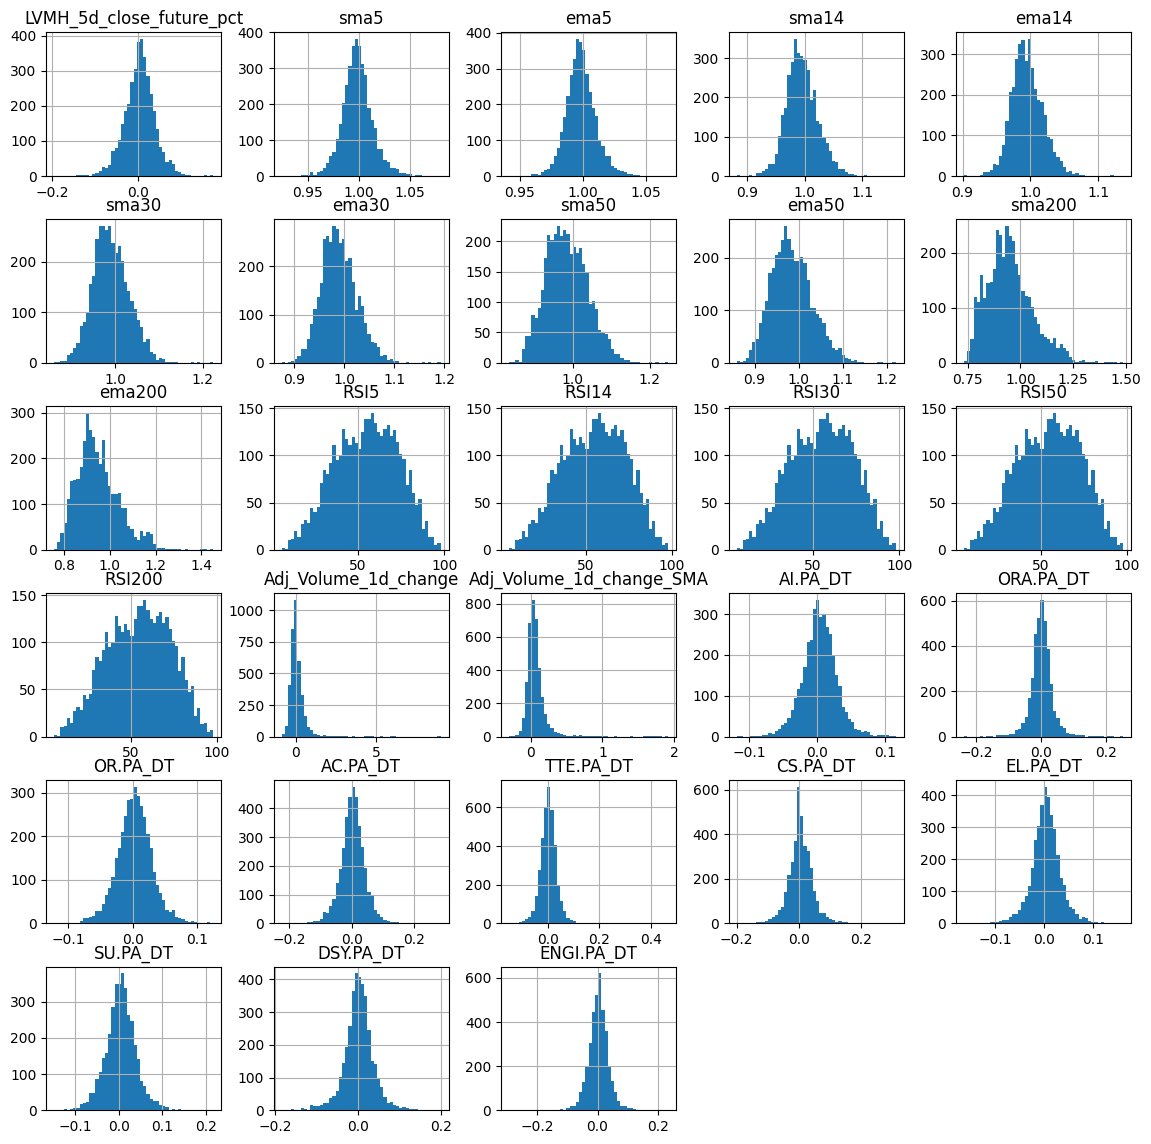

In [ ]:
# Histograms

clean_dataset.hist(
    bins=50, 
    sharex=False, 
    sharey=False, 
    figsize=(14,14)
)

plt.show()

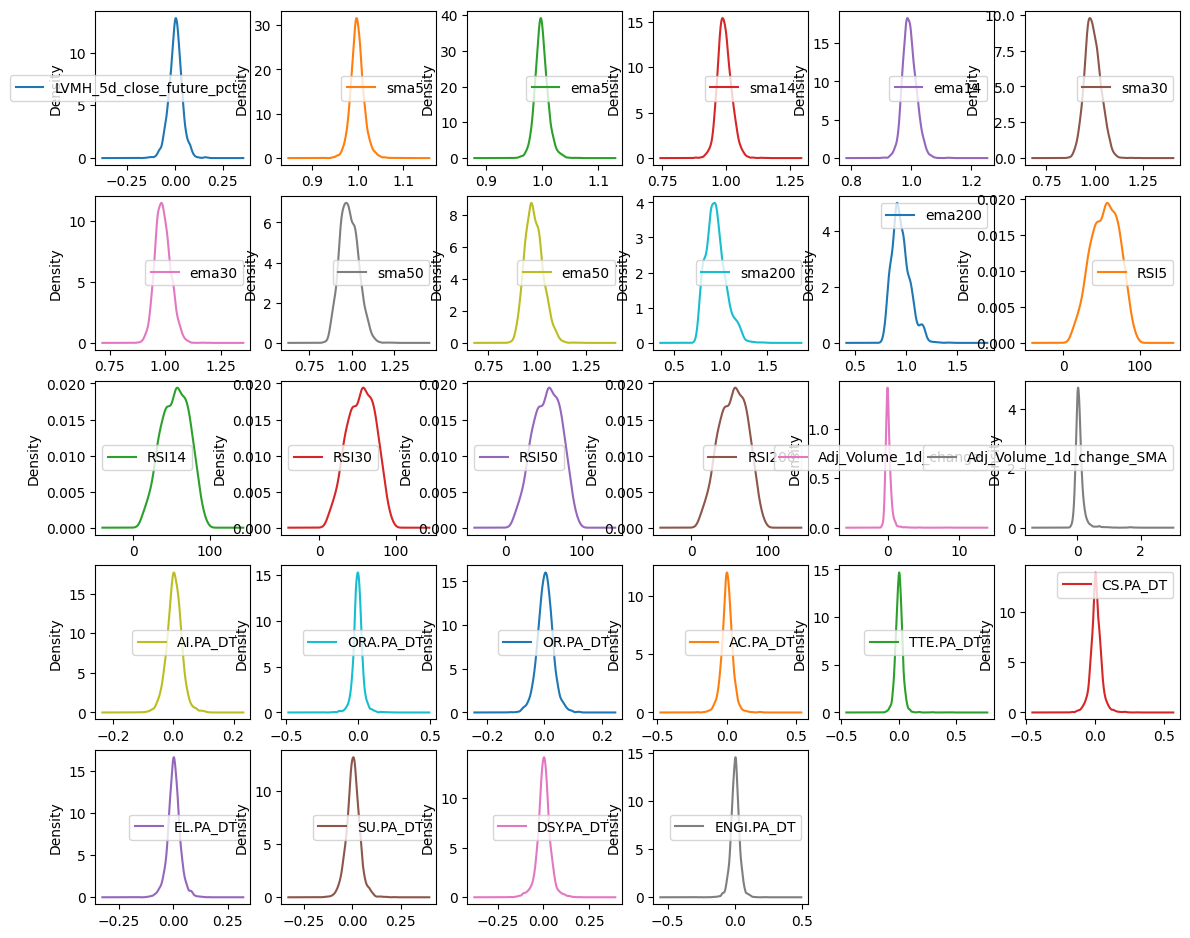

In [ ]:
# Densities

clean_dataset.plot(
    kind = 'density',
    subplots = True,
    layout=(6,6),
    sharex=False, 
    sharey=False, 
    legend = True,
    figsize=(14,14)
)

plt.show()

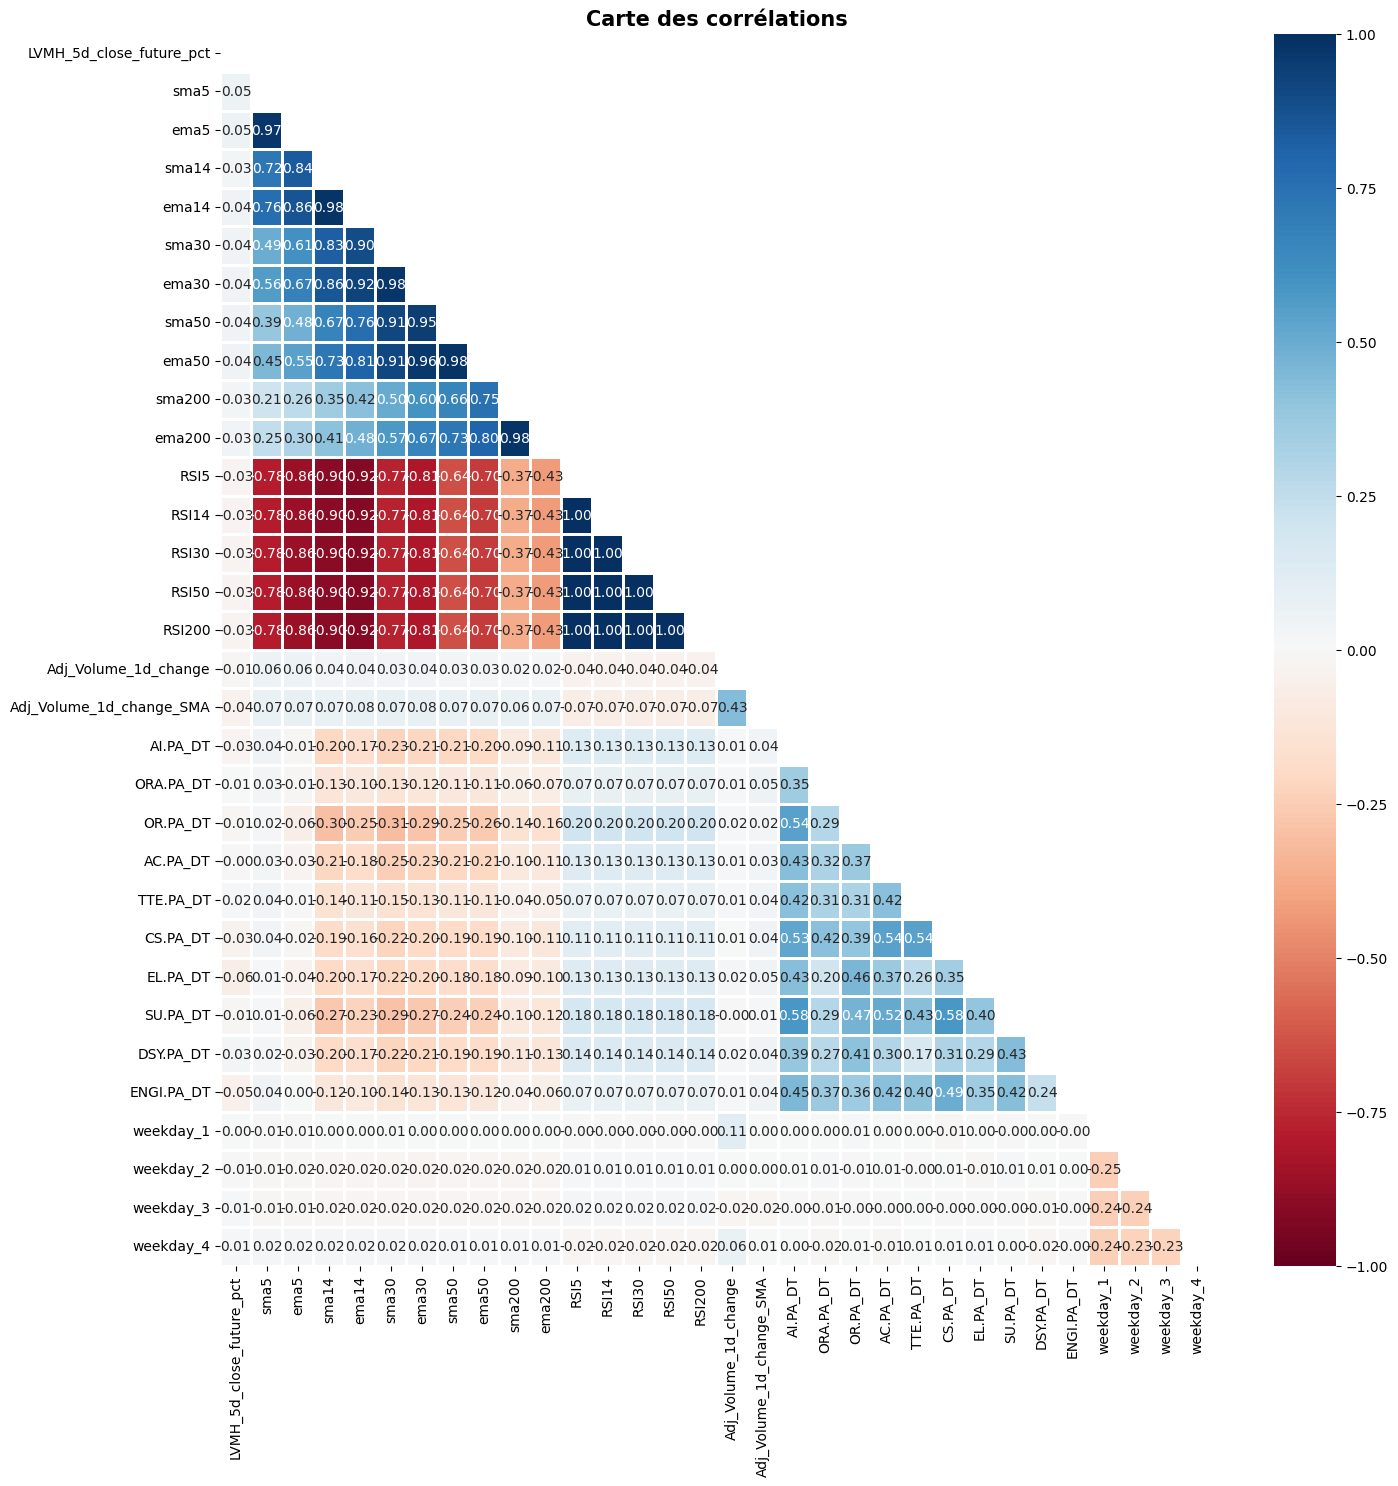

In [ ]:
# Correlation map

plt.figure(figsize=(16,16))

mask = np.triu(np.ones_like(clean_dataset.corr(), dtype=bool))

sns.heatmap(clean_dataset.corr(), 
            mask=mask, center=0, cmap='RdBu', linewidths=1, 
            annot=True, fmt=".2f", vmin=-1, vmax=1
)

plt.title('Correlation map', fontsize=15, fontweight="bold")

plt.show()

## 4 - ML Algorithms 
For time series modeling, training data must be the oldest data and test data must be the most recent data.

In [ ]:
# Training and test data

y = clean_dataset['LVMH_5d_close_future_pct']

X = clean_dataset.drop('LVMH_5d_close_future_pct', axis = 1)

validation_size = 0.25

train_size = int(len(X) * (1-validation_size))

X_train, X_test = X[0:train_size], X[train_size:len(X)]

Y_train, Y_test = y[0:train_size], y[train_size:len(X)]

In [75]:
print(X.shape)
print(y.shape)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(3748, 31)
(3748,)
(2811, 31)
(2811,)
(937, 31)
(937,)


In [ ]:
# List of algorithms to train

seed = 123

models = []

models.append(('LR', {'model':LinearRegression()}))
models.append(('LASSO', {'model':Lasso()}))
models.append(('EN', {'model':ElasticNet()}))
models.append(('KNN', {'model':KNeighborsRegressor()}))
models.append(('CART', {'model':DecisionTreeRegressor(random_state = seed)}))
models.append(('SVR', {'model':SVR()}))

models.append(('MLP', {'model':MLPRegressor(random_state = seed)}))

models.append(('ABR', {'model':AdaBoostRegressor(random_state = seed)}))
models.append(('XGBOOST', {'model':XGBRegressor(random_state=seed)}))
models.append(('GBR', {'model':GradientBoostingRegressor(random_state = seed)}))

models.append(('RFR', {'model':RandomForestRegressor(random_state = seed)}))
models.append(('ETR', {'model':ExtraTreesRegressor(random_state = seed)}))

In [80]:
algos_ml = dict(models)
algos_ml

{'LR': {'model': LinearRegression()},
 'LASSO': {'model': Lasso()},
 'EN': {'model': ElasticNet()},
 'KNN': {'model': KNeighborsRegressor()},
 'CART': {'model': DecisionTreeRegressor(random_state=123)},
 'SVR': {'model': SVR()},
 'MLP': {'model': MLPRegressor(random_state=123)},
 'ABR': {'model': AdaBoostRegressor(random_state=123)},
 'XGBOOST': {'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
      

In [ ]:
num_folds = 5
scoring = 'neg_mean_squared_error'
kfold_results = []

for model_name in algos_ml.keys():
    
    kfold = KFold(n_splits=num_folds)
    # Conversion of 'neg_mean_squared_error' to positive value to calculate RMSE (root mean squared error)
                # The lower the error, the better the model performs
    cv_results = np.sqrt(-1* cross_val_score(algos_ml[model_name]['model'], X_train, Y_train, cv=kfold, scoring=scoring))
    kfold_results.append(cv_results)
    algos_ml[model_name]['Mean CV results'] = cv_results.mean()
    algos_ml[model_name]['Std CV results'] = cv_results.std()
    
    fitted_model = algos_ml[model_name]['model'].fit(X_train, Y_train)
    algos_ml[model_name]['RMSE train'] = np.sqrt(mean_squared_error(Y_train, fitted_model.predict(X_train)))
    algos_ml[model_name]['RMSE test'] = np.sqrt(mean_squared_error(Y_test, fitted_model.predict(X_test)))
    algos_ml[model_name]['R² train'] = r2_score(Y_train, fitted_model.predict(X_train))
    algos_ml[model_name]['R² test'] = r2_score(Y_test, fitted_model.predict(X_test))

In [82]:
algos_ml

{'LR': {'model': LinearRegression(),
  'Mean CV results': np.float64(0.03425269062868173),
  'Std CV results': np.float64(0.003268100489142146),
  'RMSE train': np.float64(0.03345552797998491),
  'RMSE test': np.float64(0.03967676389681897),
  'R² train': 0.028036030395431566,
  'R² test': -0.022310949986067863},
 'LASSO': {'model': Lasso(),
  'Mean CV results': np.float64(0.03391278998040463),
  'Std CV results': np.float64(0.002967826061243005),
  'RMSE train': np.float64(0.033934605525188),
  'RMSE test': np.float64(0.039280298508966915),
  'R² train': 0.0,
  'R² test': -0.0019823819808684195},
 'EN': {'model': ElasticNet(),
  'Mean CV results': np.float64(0.03391278998040463),
  'Std CV results': np.float64(0.002967826061243005),
  'RMSE train': np.float64(0.033934605525188),
  'RMSE test': np.float64(0.039280298508966915),
  'R² train': 0.0,
  'R² test': -0.0019823819808684195},
 'KNN': {'model': KNeighborsRegressor(),
  'Mean CV results': np.float64(0.03712332978558654),
  'Std C

In [ ]:
# Better display in table format

results_metrics = pd.DataFrame.from_dict(
    algos_ml, 
    'index')[['RMSE train', 'RMSE test', 'Mean CV results', 'Std CV results', 'R² train', 'R² test']]

with pd.option_context('display.precision', 3):
    best_print = results_metrics.sort_values(by='RMSE test', ascending=True)

best_print

,RMSE train,RMSE test,Mean CV results,Std CV results,R² train,R² test
LASSO,3.393461e-02,0.039280,0.033913,0.002968,0.000000,-0.001982
EN,3.393461e-02,0.039280,0.033913,0.002968,0.000000,-0.001982
MLP,3.480791e-02,0.039354,0.035074,0.003388,-0.052132,-0.005744
LR,3.345553e-02,0.039677,0.034253,0.003268,0.028036,-0.022311
ABR,3.199942e-02,0.039889,0.034853,0.003094,0.110802,-0.033287
SVR,3.524600e-02,0.040083,0.035483,0.002528,-0.078783,-0.043365
GBR,2.784445e-02,0.040213,0.035023,0.003998,0.326726,-0.050134
RFR,1.198185e-02,0.040466,0.035218,0.003622,0.875330,-0.063412
ETR,6.102405e-17,0.041037,0.034985,0.003903,1.000000,-0.093597
KNN,3.042910e-02,0.041267,0.037123,0.002564,0.195932,-0.105921


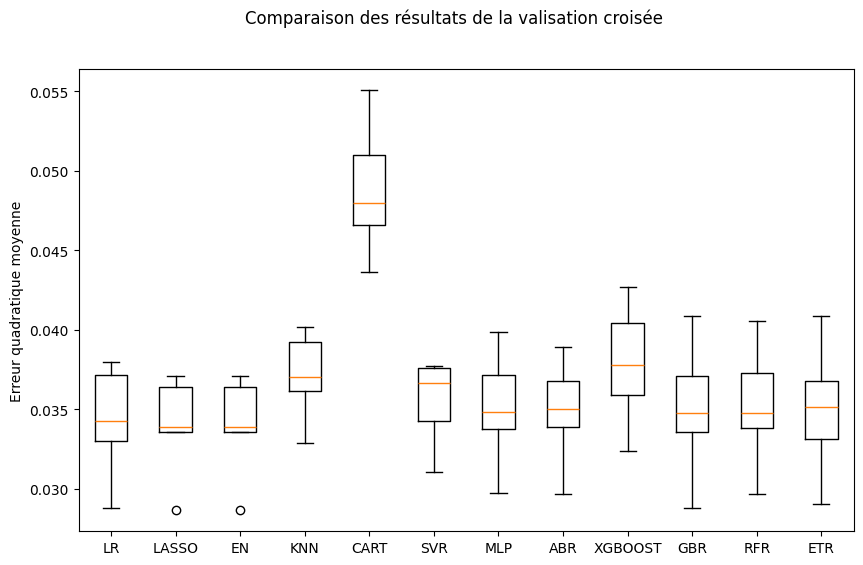

In [ ]:
# Comparison of cross-validation results

fig = plt.figure()
fig.suptitle('Comparison of cross-validation results')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(list(algos_ml.keys()))
fig.set_size_inches(10,6)
plt.ylabel('Mean squared error')
plt.show()

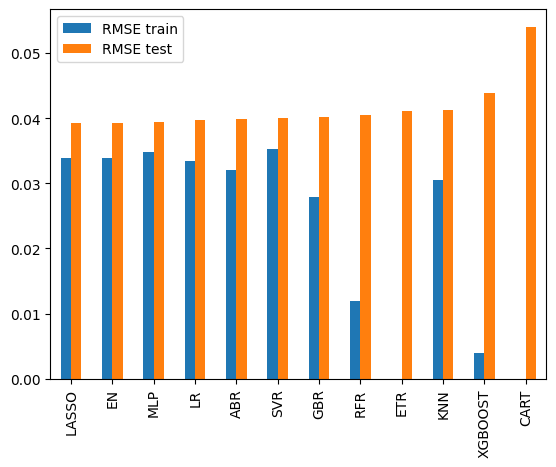

In [ ]:
# Comparison of training and test errors for all models

best_print[['RMSE train', 'RMSE test']].plot(kind = 'bar');

In [ ]:
# Final model

best_model = algos_ml['SVR']['model']
best_model

SVR()

In [ ]:
# Model evaluation function

def evaluate_model(nom_model, predictions):
    plt.figure(figsize = (10, 6))
    l1, = plt.plot(Y_test.index, np.exp(Y_test).cumprod(), label = 'Observation')
    l2, = plt.plot(Y_test.index, predictions, label = 'Prediction')
    plt.legend(handles = [l1, l2])
    plt.show()

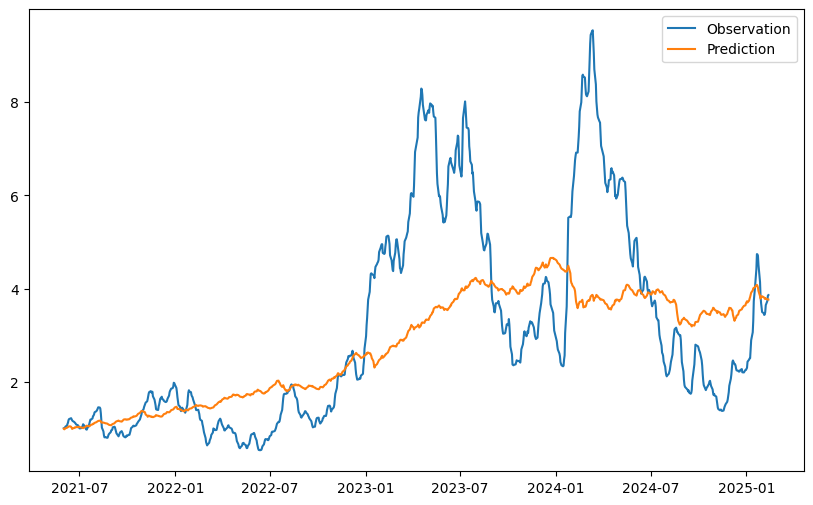

In [105]:
evaluate_model(best_model, predictions = np.exp(best_model.predict(X_test)).cumprod())

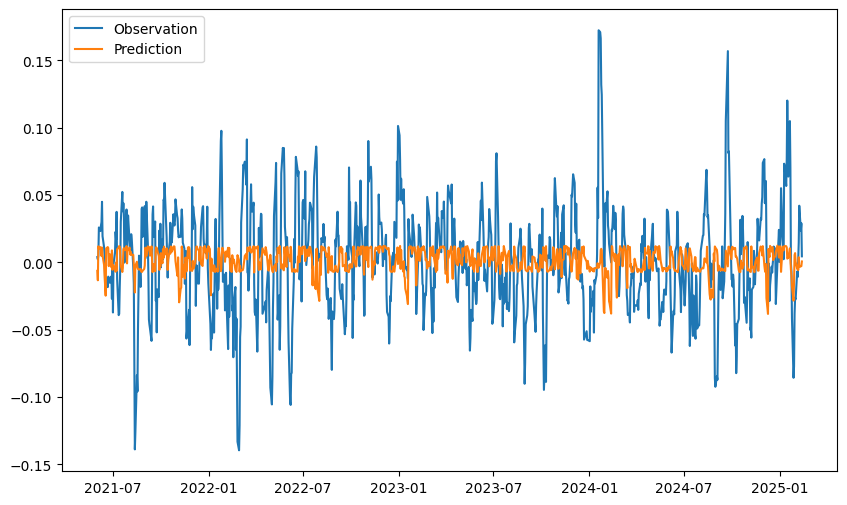

In [101]:
plt.figure(figsize = (10, 6))
l1, = plt.plot(Y_test.index, Y_test, label = 'Observation')
l2, = plt.plot(Y_test.index, best_model.predict(X_test), label = 'Prediction')
plt.legend(handles = [l1, l2])
plt.show()

In [ ]:
# Model saving

joblib.dump(value = best_model, filename = 'final_model.pkl')